# Model Selection with WBIC

In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT
from orbit.utils.simulation import make_trend, make_regression

Generate a regression problem with trend with `8` number of regressors where only `3` of them are effective. First, generate the `3` effective regressors.

In [2]:
NUM_OF_REGRESSORS = 8
NUM_OF_EFFECTIVE_REGRESSORS = 3
SERIES_LEN = 100
SEED = 20210101
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
print(regression.shape, x.shape)

# combine trend and the regression
y = trend + regression

(100,) (100, 3)


We can add `5` irrelevant regressors into the dataset to add challenge in selecting the best model.

In [3]:
x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
x = np.concatenate([x, x_extra], axis=-1)
print(x.shape)

(100, 8)


In [4]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
df.shape

(100, 10)

In [5]:
df

,y,x1,x2,x3,x4,x5,x6,x7,x8,date
0,0.545741,0.172792,0.000000,0.165219,1.227086,0.228790,-0.790759,-0.175071,-1.443387,2016-01-10
1,0.983519,-0.000000,0.452678,0.223187,-0.010755,0.932558,-1.245910,-0.263284,0.981820,2016-01-17
2,0.547457,-0.000000,0.290559,0.182286,-0.287540,1.708722,-3.212286,-1.168048,-1.044295,2016-01-24
3,-1.042535,0.147066,0.014211,0.273356,-0.344666,1.116903,-0.144973,-0.752501,0.606348,2016-01-31
4,0.810933,-0.368227,-0.081455,-0.241060,-0.224368,0.668931,0.885807,0.495612,1.909877,2016-02-07
...,...,...,...,...,...,...,...,...,...,...
95,-1.928167,0.000000,0.099649,-0.000000,1.124534,-0.048188,0.682545,-0.940672,-1.200705,2017-11-05
96,-0.278697,-0.696051,-0.112803,-0.437711,0.644461,-1.156173,-0.605925,0.234099,0.012734,2017-11-12
97,0.563077,0.500705,0.072043,0.000000,0.594366,-1.330007,-1.438340,-0.415959,-0.685047,2017-11-19
98,-1.390511,0.067311,0.000000,-0.391499,-1.460902,-0.004252,0.067180,0.946157,-0.575613,2017-11-26


Now, we can calculate WBIC and compare them across models.

In [6]:
%%time
wbics = np.empty(NUM_OF_REGRESSORS)

for idx in range(NUM_OF_REGRESSORS):
    regressor_col = x_cols[:idx + 1]

    dlt = DLT(
        response_col=response_col,
        date_col=dt_col,
        regressor_col=regressor_col,
        seed=2020,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        slope_sm_input=0.01,
        num_warmup=4000,
        num_sample=4000,
    )
    dlt.fit(df=df)
    wbic = dlt.get_training_metrics()['WBIC']
    print('Regressors:{} WBIC:{:.5f}'.format(regressor_col, wbic))
    wbics[idx] = wbic

Regressors:['x1'] WBIC:3.30243


Regressors:['x1', 'x2'] WBIC:3.32213


Regressors:['x1', 'x2', 'x3'] WBIC:3.28619


Regressors:['x1', 'x2', 'x3', 'x4'] WBIC:3.29544


Regressors:['x1', 'x2', 'x3', 'x4', 'x5'] WBIC:3.34317


Regressors:['x1', 'x2', 'x3', 'x4', 'x5', 'x6'] WBIC:3.38635


Regressors:['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'] WBIC:3.42989


Regressors:['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'] WBIC:3.45579
CPU times: user 3.69 s, sys: 1.81 s, total: 5.5 s
Wall time: 1min 25s


We plot the chart with WBICs against number of regressors included.  As we can see, WBIC is lowest when regressors overlapped exactly with the truth.

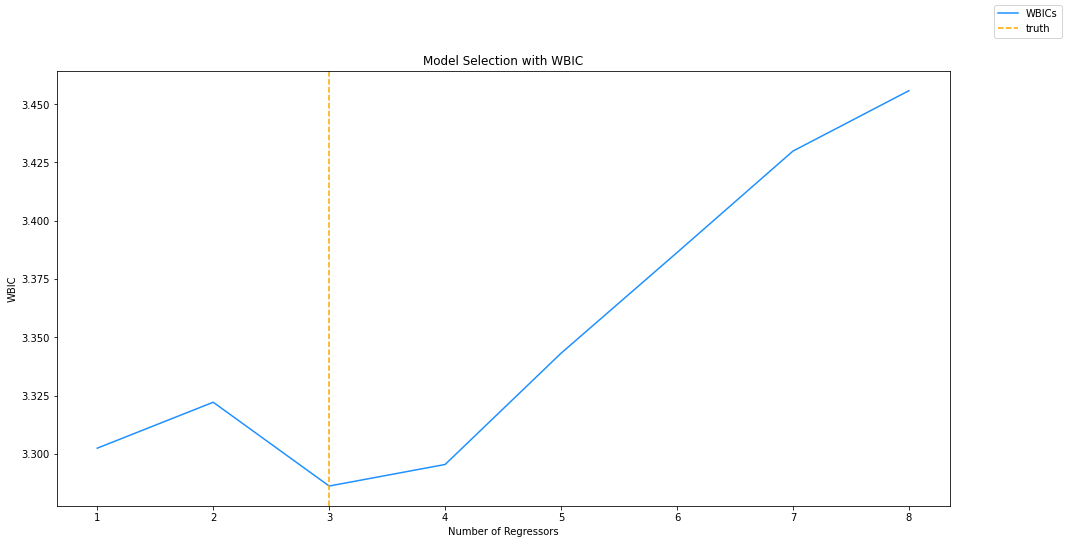

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(np.arange(1, NUM_OF_REGRESSORS + 1), wbics, color='dodgerblue', label='WBICs')
ax.axvline(x=3, linestyle='--', color='orange', label='truth')
ax.set_xlabel('Number of Regressors')
ax.set_ylabel('WBIC')
ax.set_title('Model Selection with WBIC')
fig.legend()